In [1]:
# Подключаем требуемые библиотеки
import numpy as np
import pandas as pd
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler

import lightgbm as lgbm

In [2]:
# Игнорируем предупреждения
import warnings
warnings.simplefilter('ignore')

In [3]:
# Пишем классы кодирования признаков
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional 
    transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, x):
        return x[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional 
    transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, x):
        return x[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, x, y=None):
        self.columns = [col for col in pd.get_dummies(x, prefix=self.key).columns]
        return self

    def transform(self, x):
        x = pd.get_dummies(x, prefix=self.key)
        test_columns = [col for col in x.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                x[col_] = 0
        return x[self.columns]

In [4]:
# Функция отрисовки матрицы ошибок
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
# Функция обучения модели, кросс-валидации и подсчета DS-метрик
def model_metrics(model, name, x_train, x_test, y_train, y_test):
    
    cv_scores = cross_val_score(model, x_train, y_train, cv=5, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)

    # обучение модели и предсказание
    model.fit(x_train, y_train)
    y_pred = model.predict_proba(x_test)[:, 1]

    # поиск оптимальной границы
    b = 1
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_pred)
    fscore = (1 + b ** 2) * (precision * recall) / (b ** 2 * precision + recall)
    ix = np.argmax(fscore)

    # визуализация матрицы ошибок
    font = {'size' : 15}

    plt.rc('font', **font)

    cnf_matrix = confusion_matrix(y_test, y_pred > thresholds[ix])
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix, classes=['Cardio_0', 'Cardio_1'],
                          title='Confusion matrix')
    plt.show()

    # возвращаем метрики
    return {'model': name,
            'threshold': round(thresholds[ix], 3),
            'precision': round(precision[ix], 3),
            'recall': round(recall[ix], 3),
            'fscore': round(fscore[ix], 3),
            'roc_auc': round(roc_auc_score(y_test, y_pred), 3),
            'cv_roc_auc': round(cv_score, 3),
            'cv_roc_auc_std': round(cv_score_std, 3)
            }

In [6]:
# Считываем датасет
df = pd.read_csv('train_case2.csv', sep=';')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [7]:
# Разбиваем данные на тренировочные и тестовые
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=['cardio']), 
                                                    df['cardio'], random_state=42)

In [8]:
# Обрабатываем признаки
continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

# Объединяем пайплайны признаков в один
feats = FeatureUnion(continuos_transformers + cat_transformers + base_transformers)   

**Логистическая регрессия**

In [9]:
clf_lr = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(random_state=42)),
])

Confusion matrix, without normalization
[[4810 3878]
 [1433 7379]]


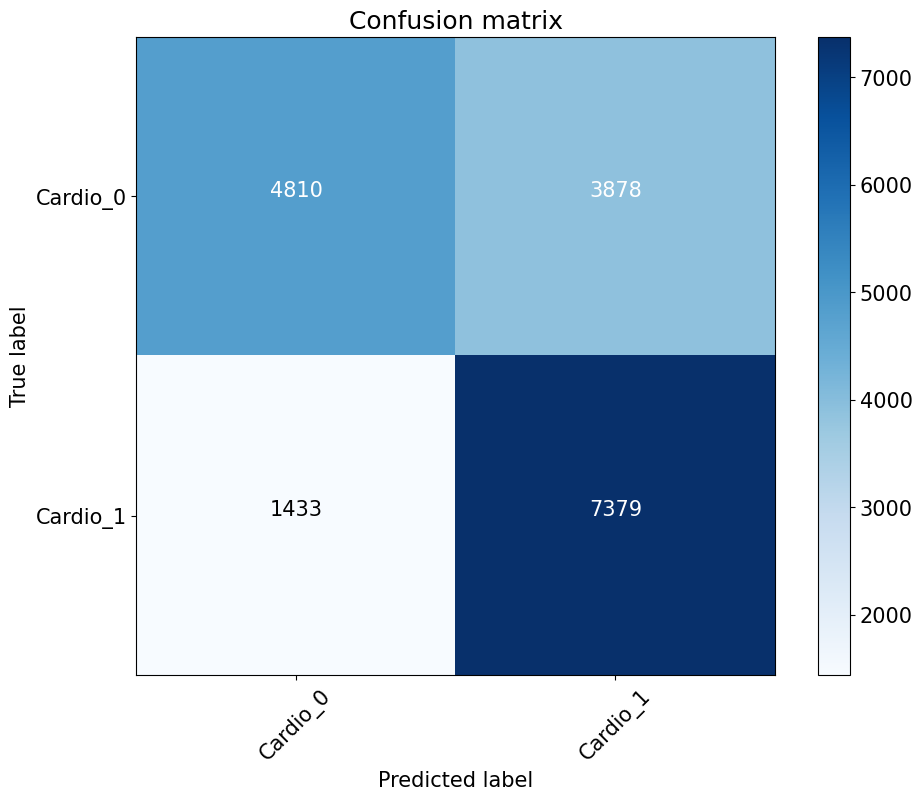

In [10]:
metrics_lr = model_metrics(clf_lr, 'Logistic Regression', x_train, x_test, y_train, y_test)

**LightGBM**

In [11]:
lightgbm = Pipeline([
    ('features', feats),
    ('classifier', lgbm.LGBMClassifier(random_state=42)),
])

Confusion matrix, without normalization
[[5846 2842]
 [1881 6931]]


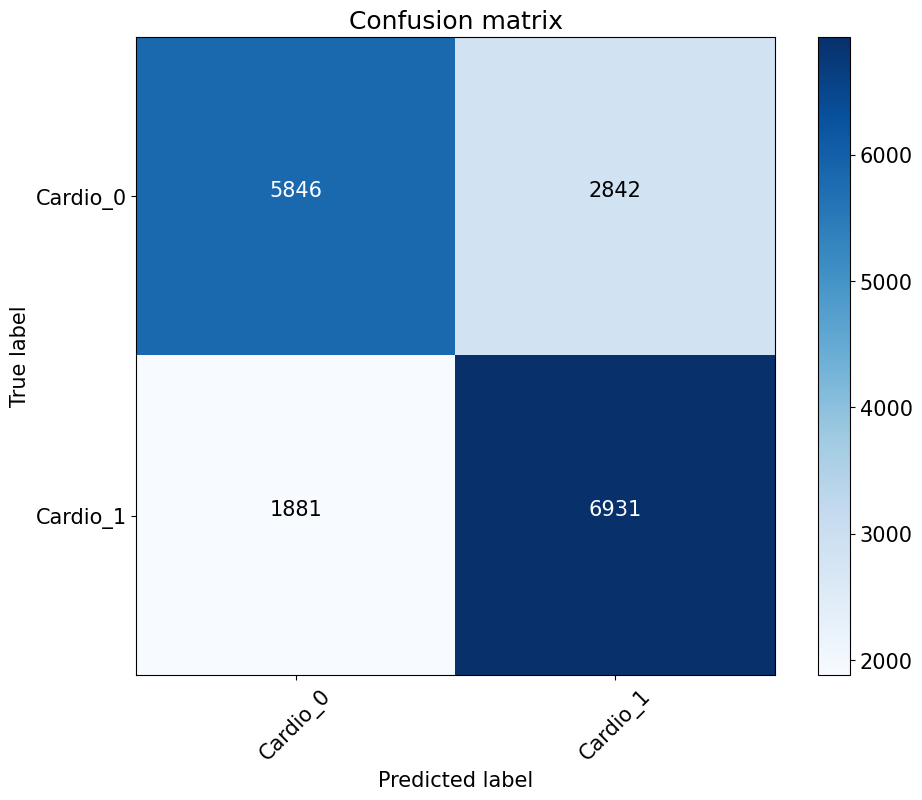

In [12]:
metrics_lightgbm = model_metrics(lightgbm, 'LightGBM', x_train, x_test, y_train, y_test)

**Random Forest**

In [13]:
forest = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(n_estimators=100)),
])

Confusion matrix, without normalization
[[4558 4130]
 [1501 7311]]


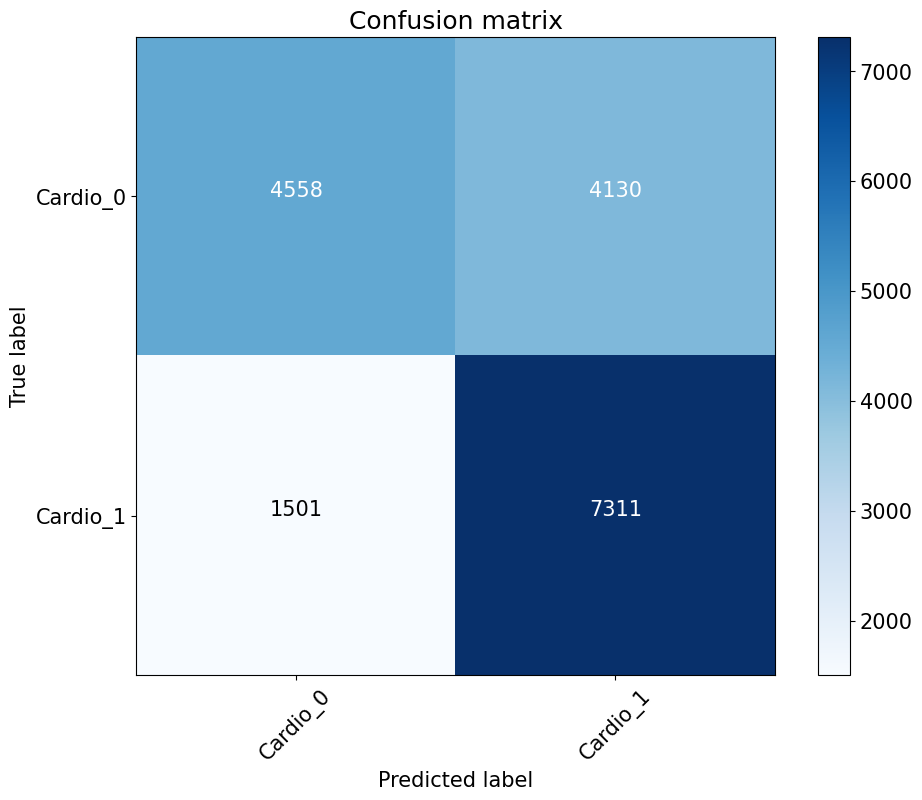

In [14]:
metrics_forest = model_metrics(forest, 'Random Forest', x_train, x_test, y_train, y_test)

In [15]:
df_metrics = pd.DataFrame.from_records([metrics_lr, metrics_lightgbm, metrics_forest])
df_metrics

,model,threshold,precision,recall,fscore,roc_auc,cv_roc_auc,cv_roc_auc_std
0,Logistic Regression,0.397,0.656,0.837,0.735,0.785,0.782,0.003
1,LightGBM,0.407,0.709,0.787,0.746,0.803,0.802,0.004
2,Random Forest,0.333,0.639,0.830,0.722,0.771,0.775,0.003


Лучшие результаты показала модель градиентного бустинга - Light GBM. Все метрики, кроме recall, у нее выше (даже среднеквадратичное отклонение при кросс-валидации!). Однако в случае с сердечно-сосудистыми заболеваниями, как мы уже говорили, эта метрика имеет часто решающее значение, поэтому пренебречь ею нельзя (на нашей выборке доля ложных пропусков - это почти 400 человек! Из 17.5 тысяч). Тогда лучшим решением будет использовать логистическую регрессию - она продемонстрировала самый высокий recall из рассмотренных нами моделей - он на 5% выше, чем у Light GBM.

Если посмотреть эти записи, становится очевидным, что первая модель, конечно же, лучше. Вторая модель ложно сработала на 910 объекте - это в 91 раз больше ошибки первой модели. Именно это число мы можем увидеть в метрике False Positive Rate. Но несмотря на такую высокую точность, эти числа все еще очень малы, чтобы сразу глазами увидеть эту разницу (которая очевидна на матрице ошибок). Зато она сразу видна на метрике precision - precision первой модели стремится скорее к единице (0.9), а precision второй модели - к нулю (0.09). Нам кажется, что обе метрики устойчивы к дисбалансу классов и подходят для использования в такой ситуации. С другой стороны, мы не рисовали кривые, а только проанализировали матрицу ошибок с помощью этих метрик. Возможно, с визуализацией ответ будет более однозначным.